In [178]:
#importing the necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

In [102]:
#loading the data frame

data=pd.read_csv('Fraud.csv')
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [103]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [104]:
#checking for null values

data.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [105]:
#checking for multicollinearity in data using variance inflation factor

num_cols=['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']

# the independent variables set
X = data[num_cols]
  
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

          feature         VIF
0          amount    3.861988
1   oldbalanceOrg  464.011728
2  newbalanceOrig  465.356124
3  oldbalanceDest   70.452251
4  newbalanceDest   82.167173


We notice that oldbalanceOrg is highly correlated with newbalanceOrig and oldbalanceDest is correlated with newbalanceDest. To take care of this we remove the features oldbalanceOrgand and newbalanceOrig since the feature amount = newbalanceOrig - oldbalanceOrg captures the information in both. Alse we introduce a new feature amount_dest = newbalanceDest - oldbalanceDest and remove newbalanceDest and oldbalanceDest.

In [106]:
data['amount_dest']=data['newbalanceDest']-data['oldbalanceDest']
data.drop(['oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest'],axis=1,inplace=True)
data.head()

,step,type,amount,nameOrig,nameDest,isFraud,isFlaggedFraud,amount_dest
0,1,PAYMENT,9839.64,C1231006815,M1979787155,0,0,0.0
1,1,PAYMENT,1864.28,C1666544295,M2044282225,0,0,0.0
2,1,TRANSFER,181.00,C1305486145,C553264065,1,0,0.0
3,1,CASH_OUT,181.00,C840083671,C38997010,1,0,-21182.0
4,1,PAYMENT,11668.14,C2048537720,M1230701703,0,0,0.0


In [107]:
#dataset is highly imbalanced

data.isFraud.value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

To take care of this imbalance in data we will use a technique called undersampling. Using it we will make the number of entries both the classes equal. We use undersampling because the dataset is very large and we have limited resources.

In [108]:
X=data[['type','amount','amount_dest','isFlaggedFraud']]
Y=data['isFraud']
sampler=RandomUnderSampler(sampling_strategy='majority',random_state=42)
X,Y=sampler.fit_resample(X,Y)

data=X.join(Y)

# Basic Data Visualization

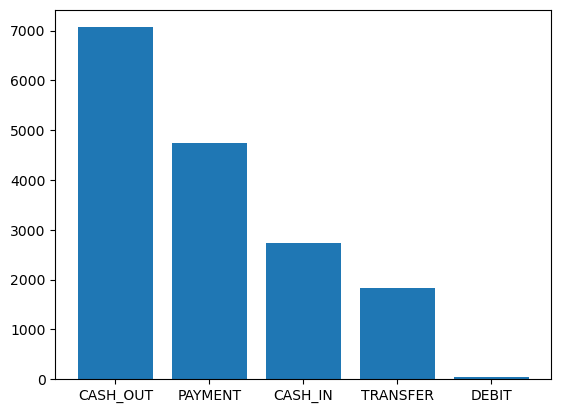

In [109]:
plt.bar(height=np.array(data['type'].value_counts()),x=data['type'].unique());

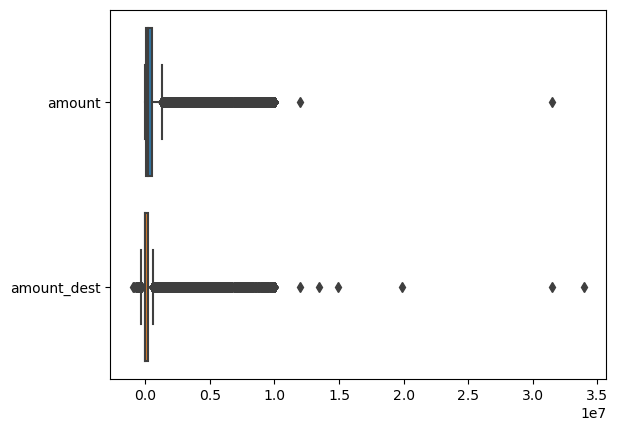

In [110]:
#dataset contains outliers

sns.boxplot(data=data[['amount','amount_dest']],orient='h');

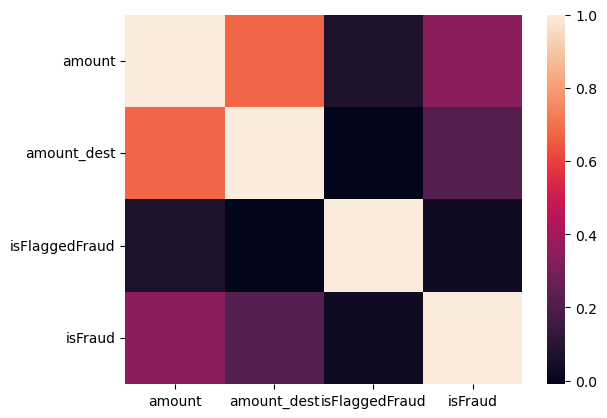

In [111]:
sns.heatmap(data.corr());

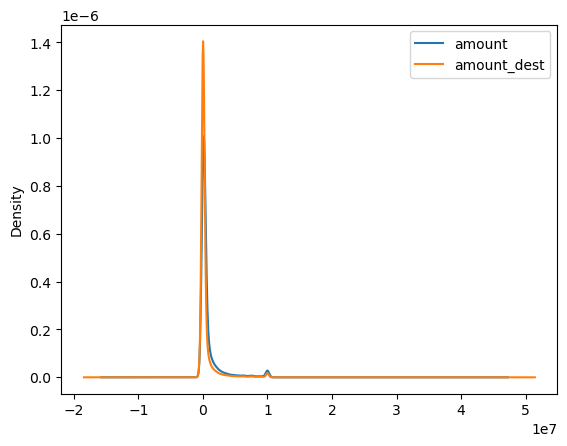

In [112]:
ax=data[['amount','amount_dest']].plot.kde()

# Removing outliers

In [113]:
data.describe()

,amount,amount_dest,isFlaggedFraud,isFraud
count,1.642600e+04,1.642600e+04,16426.000000,16426.000000
mean,8.248655e+05,4.296122e+05,0.000974,0.500000
std,1.862573e+06,1.443078e+06,0.031196,0.500015
min,0.000000e+00,-9.619821e+05,0.000000,0.000000
25%,3.815791e+04,0.000000e+00,0.000000,0.000000
50%,1.752676e+05,0.000000e+00,0.000000,0.500000
75%,5.404362e+05,2.272079e+05,0.000000,1.000000
max,3.147911e+07,3.394650e+07,1.000000,1.000000


In order to remove outliers, we use the Inter Quartile Range (Q3-Q1) and remove values > (Q3+1.5 x IQR) and < (Q1-1.5 x IQR)

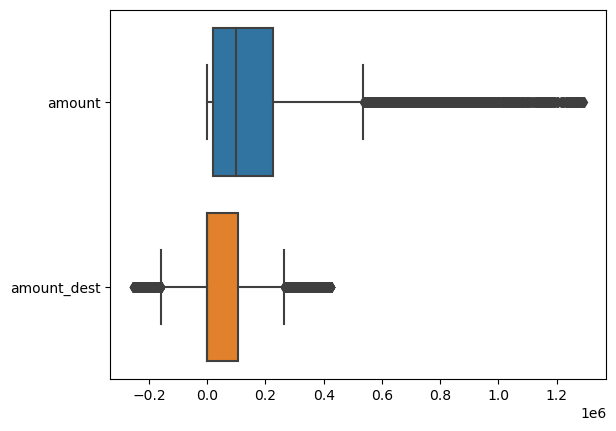

In [114]:
def remove_outliers(col):
    Q1 = np.quantile(data[col], 0.25)                 
    Q3 = np.quantile(data[col], 0.75)
    IQR = Q3 - Q1

    upper = Q3+1.5*IQR
    lower = Q1-1.5*IQR 

    data.drop(data[(data[col]<lower) | (data[col]>upper)].index,inplace=True)


for col in ['amount','amount_dest']:
    remove_outliers(col)
    
sns.boxplot(data=data[['amount','amount_dest']],orient='h');

# Encoding categorical data

In [115]:
encoder=OneHotEncoder(categories='auto')
data=pd.DataFrame(pd.get_dummies(data,columns=['type']))

data.head()

,amount,amount_dest,isFlaggedFraud,isFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,183806.32,183806.32,0,0,0,1,0,0,0
1,521.37,0.00,0,0,0,0,0,1,0
2,3478.18,0.00,0,0,0,0,0,1,0
3,1716.05,0.00,0,0,0,0,0,1,0
4,253129.93,-253129.93,0,0,1,0,0,0,0


In [127]:
#separating features from labels and splitting the data into training and test set

X=data[['amount','amount_dest','isFlaggedFraud','type_CASH_IN','type_CASH_OUT','type_DEBIT','type_PAYMENT','type_TRANSFER']]
Y=data['isFraud']

X.shape

X_train,X_test,Y_train,Y_test=train_test_split(X,Y,stratify=Y,test_size=0.2,random_state=42)

In [193]:
#finding the best hyperparameters that maximize precision for the XGBoost random forest classifier
model=xgb.XGBRFClassifier()

parameters = {
    'max_depth': range (2, 12, 2),
    'n_estimators': range(60, 240, 60),
    'learning_rate': [0.1]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = 4,
    cv = 10,
    verbose=True
)

model_grid = grid_search.fit(X_train,Y_train)

print('Best hyperparameters are: '+str(model_grid.best_params_))
print('Best score is: '+str(model_grid.best_score_))

Fitting 10 folds for each of 15 candidates, totalling 150 fits
Best hyperparameters are: {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 120}
Best score is: 0.9322366107011437


In [194]:
#training the model using the best hyperparameters

model=xgb.XGBRFClassifier(learning_rate=0.1, max_depth=8, n_estimators=120)
model.fit(X_train,Y_train)

XGBRFClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                colsample_bylevel=1, colsample_bytree=1,
                early_stopping_rounds=None, enable_categorical=False,
                eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
                grow_policy='depthwise', importance_type=None,
                interaction_constraints='', learning_rate=0.1, max_bin=256,
                max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
                max_depth=8, max_leaves=0, min_child_weight=1, missing=nan,
                monotone_constraints='()', n_estimators=120, n_jobs=0,
                num_parallel_tree=120, objective='binary:logistic',
                predictor='auto', random_state=0, ...)

In [199]:
predictions=model.predict(X_test)
confusion_matrix(predictions,Y_test)

array([[1381,  335],
       [  78,  657]], dtype=int64)

We are mainly concerned with the precision score since we aim to minimize the number of false positives so that a legit transaction is not labelled as fraud.

In [200]:
precision_score(predictions,Y_test)

0.6622983870967742

# Calculating Feature Importance 

<AxesSubplot:>

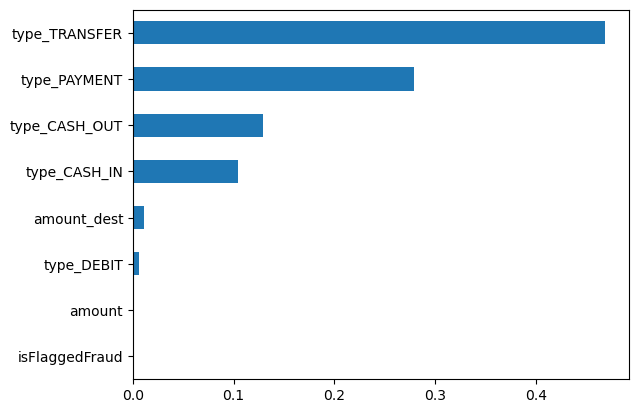

In [201]:
feat_importances = pd.Series(model.feature_importances_, index = X_train.columns).sort_values(ascending = True)
feat_importances.plot(kind = 'barh');

The most important feature is the type transfer (contrary to my belief of amount). Most of the fraudulent transactions are completed using transfer followed by payment type. The company should monitor the customers who use tranfer and payment types. Also, the attempt to flag illegal transaction by the company is futile and the company should consider changing it.